In [44]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
import seaborn as sns
from analysis.utils import module_reload
module_reload('analysis')
from analysis.import_data import import_true_reco
from analysis.plot_matplotlib import export_figures

In [2]:
df = import_true_reco(normalize=True)
repo_dir = '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP'

Using cached file from /nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/cache/compare_truejet_matchingreco.root_zhh_zzh.npy


Sklearn

In [3]:
lepton_columns = [[f'lep{i}_px', f'lep{i}_py', f'lep{i}_pz', f'lep{i}_e'] for i in range(1,3)]
jet_columns    = [[f'jet{i}_px', f'jet{i}_py', f'jet{i}_pz', f'jet{i}_e'] for i in range(1,5)]
print(lepton_columns, jet_columns)

[['lep1_px', 'lep1_py', 'lep1_pz', 'lep1_e'], ['lep2_px', 'lep2_py', 'lep2_pz', 'lep2_e']] [['jet1_px', 'jet1_py', 'jet1_pz', 'jet1_e'], ['jet2_px', 'jet2_py', 'jet2_pz', 'jet2_e'], ['jet3_px', 'jet3_py', 'jet3_pz', 'jet3_e'], ['jet4_px', 'jet4_py', 'jet4_pz', 'jet4_e']]


In [4]:
module_reload('analysis')
from analysis.mem_ana import constants, sig_to_bkg
from analysis.mem_ana import load_results
from math import floor

np.random.seed(42)

zhh_indices = df[df['is_zhh'] == True].index
zzh_indices = df[df['is_zzh'] == True].index

n_zhh = len(zhh_indices)
n_zzh = len(zzh_indices)

assert(abs(sig_to_bkg() * n_zzh - n_zhh) < 1)

print(f'ZHH: {n_zhh}\nZZH: {n_zzh}')

ZHH: 14638
ZZH: 28667


In [5]:
def df_dummy(length:int=100):
    res = {}
    
    lepton_columns  = [[f'lep{i}_px', f'lep{i}_py', f'lep{i}_pz', f'lep{i}_e'] for i in range(1,3)]
    jet_columns     = [[f'jet{i}_px', f'jet{i}_py', f'jet{i}_pz', f'jet{i}_e'] for i in range(1,5)]
    feature_columns = flatten_list(lepton_columns + jet_columns)
    
    for i, col in enumerate(feature_columns):
        #res[col] = np.chararray(length)
        res[col] = i*np.ones(length, dtype=int)
        
    res['is_zhh'] = 24*np.ones(length, dtype=int)
        
    return pd.DataFrame(res)

In [6]:
from torch.utils.data import Dataset, DataLoader, random_split
from typing import Optional, List, Tuple, Union
import random

def flatten_list(xss:List):
    return [x for xs in xss for x in xs]

def get_data(df, uncorrelated:bool=True, flatten:bool=True,
             length:Optional[int]=None, random_state:int=42,)->Tuple[np.ndarray, np.ndarray]:
    
    lepton_columns = [[f'lep{i}_px', f'lep{i}_py', f'lep{i}_pz', f'lep{i}_e'] for i in range(1,3)]
    jet_columns    = [[f'jet{i}_px', f'jet{i}_py', f'jet{i}_pz', f'jet{i}_e'] for i in range(1,5)]
    
    if length is None: length = len(df)
    if uncorrelated:
        random.seed(random_state)
        if flatten:
            X = np.zeros((length, 24), dtype=float)
        
            for i in range(length):
                random.shuffle(jet_columns)
                X[i, :] = df.iloc[i][flatten_list(lepton_columns + jet_columns)]
                
        else:            
            X = np.zeros((length, 6, 4), dtype=float)
            
            for i in range(length):
                random.shuffle(jet_columns)
                X[i,  :2] = df.iloc[i][lepton_columns[0]], df.iloc[i][lepton_columns[1]]
                X[i, 2:6] = df.iloc[i][jet_columns[0]], df.iloc[i][jet_columns[1]], df.iloc[i][jet_columns[2]], df.iloc[i][jet_columns[3]]
    else:
        if flatten:
            feature_columns = lepton_columns + jet_columns
            feature_columns = np.array(feature_columns)
            feature_columns = feature_columns.flatten().tolist()
            
            X = df.iloc[:length][feature_columns]
        else:
            #raise Exception('Not implemented')
            X = np.hstack((
                np.array([df.iloc[:length][lepton_columns[i]] for i in range(2)]).swapaxes(0,1),
                np.array([df.iloc[:length][jet_columns[i]] for i in range(4)]).swapaxes(0,1)
            ))
    
    y = df['is_zhh']
    
    return X, np.array(y)

class DiHiggsDataset(Dataset):
    def __init__(self, df:pd.DataFrame, device:Optional[Union[str,torch.device]]='cpu',
                 seed:Optional[int]=None,
                 autoshuffle_rows:bool=True,
                 sort_rows_by_energy:bool=False) -> None:
        
        if autoshuffle_rows and sort_rows_by_energy:
            raise Exception('Can not fulfill both autoshuffle_rows and sort_rows_by_energy')
        
        X, y = get_data(df, uncorrelated=False, flatten=False)

        self.dX = torch.as_tensor(X, device=device, dtype=torch.float)
        self.dy = torch.as_tensor(y, device=device, dtype=torch.float).reshape(-1, 1)
        
        self.autoshuffle_rows = autoshuffle_rows
        self.sort_rows_by_energy = sort_rows_by_energy
        
        if seed:
            torch.manual_seed(seed)
    
    def __len__(self):
        return len(self.dX)
    
    def __getitem__(self, index):
        if self.autoshuffle_rows:
            jet_idx = 2 + torch.randperm(4)
        elif self.sort_rows_by_energy:
            jet_idx = 2 + torch.argsort(self.dX[index][2:, 3])
        else:
            jet_idx = torch.tensor([2,3,4,5])
            
        return (torch.vstack((self.dX[index][:2], self.dX[index][jet_idx])), self.dy[index])

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from typing import Optional, Tuple

def get_predictions(model:nn.Module, ds_test:torch.utils.data.dataset.Dataset, with_sigmoid:bool=True):
    y_test = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for i in range(len(ds_test)):
            y_pred = model(ds_test[i][0].unsqueeze(0))
            y_pred = y_pred.sigmoid().cpu().item() if with_sigmoid else y_pred.cpu().item()
            
            y_test.append(y_pred)
            y_true.append(ds_test[i][1].cpu().item())
    
    return y_test, y_true

def check_model_roc(predictions:Optional[Tuple]=None,
                    model:Optional[nn.Module]=None, ds:Optional[torch.utils.data.dataset.Dataset]=None,
                    with_sigmoid:bool=True):
    
    if predictions is None:
        predictions = get_predictions(model, ds, with_sigmoid=with_sigmoid)
        
    y_test, y_true = predictions
        
    fpr, tpr, thresholds = roc_curve(y_true, y_test)
    AUC = roc_auc_score(y_true, y_test)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set_title(f'AUC = {AUC:.2f}')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    
    return predictions, fig

def check_model_precrec(predictions:Optional[Tuple]=None,
                    model:Optional[nn.Module]=None, ds:Optional[torch.utils.data.dataset.Dataset]=None,
                    with_sigmoid:bool=True):
    if predictions is None:
        predictions = get_predictions(model, ds, with_sigmoid=with_sigmoid)
        
    y_test, y_true = predictions
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_test)
    AUC = auc(recall, precision)

    fig, ax = plt.subplots()
    ax.plot(recall, precision)
    ax.set_title(f'AUC = {AUC:.2f}')
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')
    
    return predictions, fig

def get_ds(autoshuffle_rows:bool=True, sort_rows_by_energy:bool=False,
           shuffle_ds:bool=True, batch_size:int=2048,
           device:Optional[Union[str,torch.device]]=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    
    if torch.cuda.is_available():
        print(torch.cuda.get_device_name())
        
    ds = DiHiggsDataset(df, device=device, autoshuffle_rows=autoshuffle_rows, sort_rows_by_energy=sort_rows_by_energy)

    generator = torch.Generator()
    generator.manual_seed(42)

    tot_size = len(ds)
    test_fraction = 0.2

    test_size = int(tot_size*test_fraction)
    train_size = tot_size - test_size

    ds_train, ds_test = random_split(dataset=ds, lengths=[train_size, test_size], generator=generator)

    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=shuffle_ds)
    test_loader  = DataLoader(ds_test , batch_size=batch_size, shuffle=shuffle_ds)
    
    return ds, ds_train, ds_test, train_loader, test_loader

from tqdm.auto import tqdm

def train(model, loader, n_epochs:int=100, lr:float=1e-2, with_sigmoid:bool=True):
    """_summary_

    Args:
        model (_type_): _description_
        loader (_type_): _description_
        n_epochs (int, optional): _description_. Defaults to 100.
        lr (float, optional): _description_. Defaults to 1e-2.
        with_sigmoid (bool, optional): whether or not to apply a final sigmoid. Defaults to False.

    Returns:
        _type_: _description_
    """
    losses = []
    opt = torch.optim.Adam(model.parameters(), lr)
    
    loss_func = torch.nn.functional.binary_cross_entropy_with_logits if with_sigmoid else torch.nn.functional.binary_cross_entropy
    
    pbar = tqdm(range(n_epochs))
    model.train()
    for n_epoch in pbar:
        for i_batch, sample in enumerate(loader):
            opt.zero_grad()
            
            X = sample[0]
            y_true = sample[1]
            
            y_pred = model(X)
            
            n_zhh = y_true.sum().item()
            n_zzh = loader.batch_size - y_true.sum().item()
            btos = n_zzh/n_zhh
            
            loss = loss_func(y_pred, y_true, pos_weight=torch.tensor(btos)) #loss_func(y_pred, y_true) # 
            losses.append(loss.item())
            
            loss.backward()
            opt.step()
            
            pbar.set_description(f'Epoch {n_epoch} | Batch {i_batch} | Loss {loss.item()} | ZHH {n_zhh} | ZZH {n_zzh}')
            
            #if i % 500 == 0:
            #    print(float(loss))
        
    return losses

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ds, ds_train, ds_test, train_loader, test_loader = get_ds(autoshuffle_rows=False, device=device)

Tesla V100-PCIE-32GB


Torch

In [8]:
if False:
    cheap = make_mlp(5, 24, hidden_channels=256, out_features=1, pre_layers=[nn.Flatten()], post_layers=[nn.Sigmoid()]).to(device)

    print('Model: %s\nParameters: %i' %
                (cheap, sum(p.numel() for p in cheap.parameters())))

In [9]:
from itertools import permutations

In [10]:
perms = torch.tensor(list(permutations(list(range(4)))), dtype=torch.int)
print(perms, len(perms))

tensor([[0, 1, 2, 3],
        [0, 1, 3, 2],
        [0, 2, 1, 3],
        [0, 2, 3, 1],
        [0, 3, 1, 2],
        [0, 3, 2, 1],
        [1, 0, 2, 3],
        [1, 0, 3, 2],
        [1, 2, 0, 3],
        [1, 2, 3, 0],
        [1, 3, 0, 2],
        [1, 3, 2, 0],
        [2, 0, 1, 3],
        [2, 0, 3, 1],
        [2, 1, 0, 3],
        [2, 1, 3, 0],
        [2, 3, 0, 1],
        [2, 3, 1, 0],
        [3, 0, 1, 2],
        [3, 0, 2, 1],
        [3, 1, 0, 2],
        [3, 1, 2, 0],
        [3, 2, 0, 1],
        [3, 2, 1, 0]], dtype=torch.int32) 24


In [11]:
x = torch.stack((ds[0][0], ds[1][0]))

In [13]:
x.shape

torch.Size([2, 6, 4])

In [15]:
x[:, perms].shape

torch.Size([2, 24, 4, 4])

In [51]:
zl = model.element_wise_leps(X[:, :2])
zj = model.element_wise_jets(X[:, 2:])

In [37]:
from typing import Callable
from collections import OrderedDict
from itertools import permutations

def make_mlp(nhidden:int=2, input_size:int=4, hidden_channels:int=32,
                 activation:Callable=nn.Tanh, pre_layers:Optional[List]=None,
                 post_layers:Optional[List]=None,
                 out_features:Optional[int]=None):
    
    seq = []
    
    if pre_layers is not None:
        for layer in pre_layers: seq.append(layer)
    
    for i in range(nhidden):
        seq.append(nn.Linear(input_size, hidden_channels) if (i == 0) else nn.Linear(hidden_channels, hidden_channels))
        seq.append(activation())
    seq.append(nn.Linear(hidden_channels if nhidden > 0 else input_size, out_features if out_features is not None else input_size))
    
    if post_layers is not None:
        for layer in post_layers: seq.append(layer)
    
    return nn.Sequential(*seq)

class DeepSet(nn.Module):
    def __init__(self, object_size:int, nhidden:int=2,
                 objects:List=[2,4],
                 input_size:int=4, hidden_channels:int=32, num_layers:int=3,
                 activation:Callable=nn.Tanh, use_transformer:bool=True,
                 norm:bool=False, use_janossy:bool=True):
        super().__init__()
        
        self.object_size = object_size
        self.input_size = input_size
        self.hidden_channels = hidden_channels
        
        self.perms = torch.tensor(list(permutations(list(range(4)))), dtype=torch.int)
        
        if use_transformer:
            element_wise_leps_layer = nn.TransformerEncoderLayer(d_model=4, nhead=2, batch_first=True, dim_feedforward=2048)
            element_wise_jets_layer = nn.TransformerEncoderLayer(d_model=4, nhead=2, batch_first=True, dim_feedforward=2048)
            
            element_wise_leps = [nn.TransformerEncoder(element_wise_leps_layer, num_layers=num_layers)]
            element_wise_jets = [nn.TransformerEncoder(element_wise_jets_layer, num_layers=num_layers)]
            
            if norm:
                element_wise_leps.insert(0, nn.BatchNorm1d(objects[0]))
                element_wise_jets.insert(0, nn.BatchNorm1d(objects[1]))
            
            self.element_wise_leps = nn.Sequential(*element_wise_leps)
            self.element_wise_jets = nn.Sequential(*element_wise_jets)
            
            #global_layer = nn.TransformerEncoderLayer(d_model=4, nhead=2, batch_first=True, dim_feedforward=2048)
            #self.global_net = nn.Sequential(*[
            #    global_layer,
            #    make_mlp(nhidden=0, input_size=4, out_features=1)
            #])
            
        else:
            self.element_wise_leps = make_mlp(nhidden, input_size, hidden_channels, activation, pre_layers=[nn.BatchNorm1d(objects[0])] if norm else None)
            self.element_wise_jets = make_mlp(nhidden, input_size, hidden_channels, activation, pre_layers=[nn.BatchNorm1d(objects[1])] if norm else None)
        
        if use_janossy:
            self.global_net = make_mlp(nhidden, input_size, hidden_channels, activation, out_features=1)
        else:
            self.global_net = make_mlp(1, input_size, hidden_channels, activation, out_features=1)
            self.forward = self.forward_old
        
        self.print_model_summary()
        
    def forward_old(self, X):        
        # Compat for batched learning
        if X.shape[0] == 6:
            X = X.unsqueeze(0) 
        
        #print(X.shape)
        
        zl = self.element_wise_leps(X[:, :2])
        zj = self.element_wise_jets(X[:, 2:])
        
        #print('INM', zl.shape, zj.shape)
        Z = torch.concat((zl, zj), 1)
        #print('Z-pre', Z.shape, Z)
        Z = Z.reshape(-1, self.object_size, self.input_size)

        #print('Z-post', Z.shape, Z)
        
        #pooled = Z.sum(axis=1)
        pooled = Z.mean(dim=1)
        #print('pooled', pooled.shape, pooled)
        out = self.global_net(pooled)
        #print('out', out.shape)
        
        return out
    
    def forward(self, X):        
        if X.shape[0] == 6:
            X = X.unsqueeze(0) 
        
        zl = self.element_wise_leps(X[:, :2])
        zj = self.element_wise_jets(X[:, 2:])
        
        x = zj[:, self.perms]
        
        #print('zl', zl.shape)
        #print('x', x.shape)
        
        permed_inputs = torch.cat((x, zl.unsqueeze(1).expand(-1, 24, 2, 4)), 2)
        permed_outputs = self.global_net(permed_inputs)

        #pooled = Z.sum(axis=1)
        out = permed_outputs.mean(dim=1)
        #print('pooled', pooled.shape, pooled)
        #out = self.global_net(pooled)
        
        out = out.mean(dim=1) # 1/len(self.perms)*()

        return out
    
    def print_model_summary(self):
        print(
            'Model: %s\nParameters: %i' %
            (self, sum(p.numel() for p in self.parameters()))
        )

model = DeepSet(object_size=6, nhidden=10, hidden_channels=32, norm=True).to(device)

Model: DeepSet(
  (element_wise_leps): Sequential(
    (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
          )
          (linear1): Linear(in_features=4, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=4, bias=True)
          (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (element_wise_jets): Sequential(
    (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Tran

Model: DeepSet(
  (element_wise_leps): Sequential(
    (0): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
          )
          (linear1): Linear(in_features=4, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=4, bias=True)
          (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (element_wise_jets): Sequential(
    (0): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantiz

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 199 | Batch 16 | Loss 0.9396762251853943 | ZHH 636.0 | ZZH 1412.0: 100%|██████████| 200/200 [08:56<00:00,  2.68s/it]


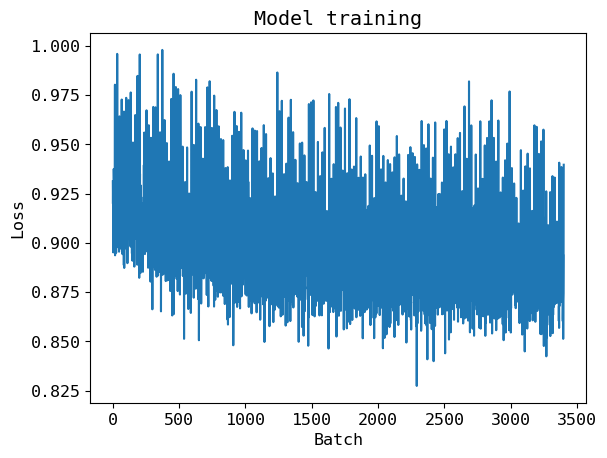

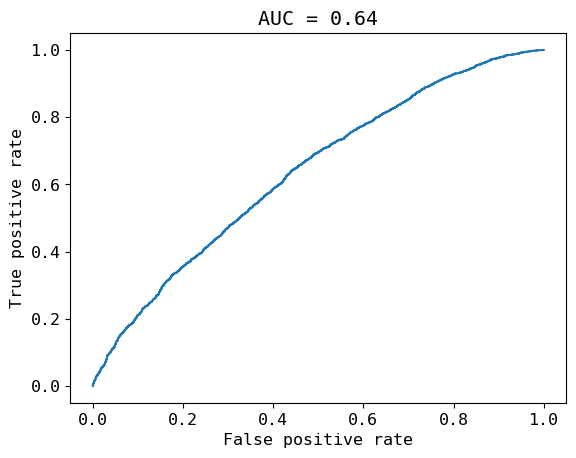

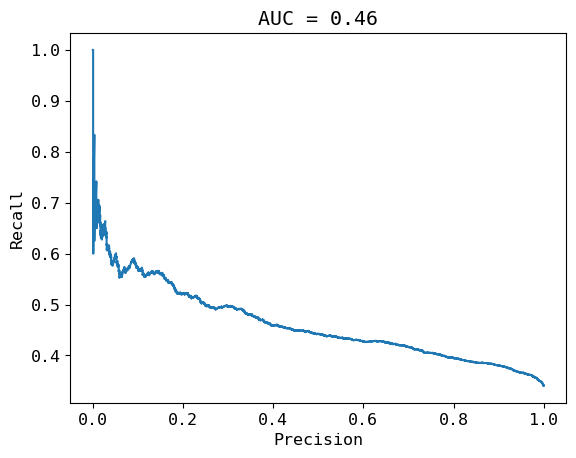

In [51]:
model = DeepSet(object_size=6, nhidden=10, hidden_channels=32, use_janossy=False).to(device)

ds, ds_train, ds_test, train_loader, test_loader = get_ds(autoshuffle_rows=True)

test = torch.stack((ds_train[0][0], ds_train[1][0]))
print(test.shape)
print(model(test))

losses = train(model, train_loader, n_epochs=200, lr=1e-4)

fig1, ax = plt.subplots()
ax.plot(np.arange(len(losses)), losses)
ax.set_xlabel(f'Batch')
ax.set_ylabel(f'Loss')
ax.set_title(f'Model training')

predictions, fig2 = check_model_roc(model=model, ds=ds_test);
predictions, fig3 = check_model_precrec(predictions=predictions);

export_figures(f'{repo_dir}/notebooks/results/6_ML_classifier_deepset.pdf', [fig1, fig2, fig3])

Janossy pooling

Model: DeepSet(
  (element_wise_leps): Sequential(
    (0): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
          )
          (linear1): Linear(in_features=4, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=4, bias=True)
          (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (element_wise_jets): Sequential(
    (0): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantiz

Epoch 199 | Batch 16 | Loss 0.9396055340766907 | ZHH 653.0 | ZZH 1395.0: 100%|██████████| 200/200 [10:52<00:00,  3.26s/it]


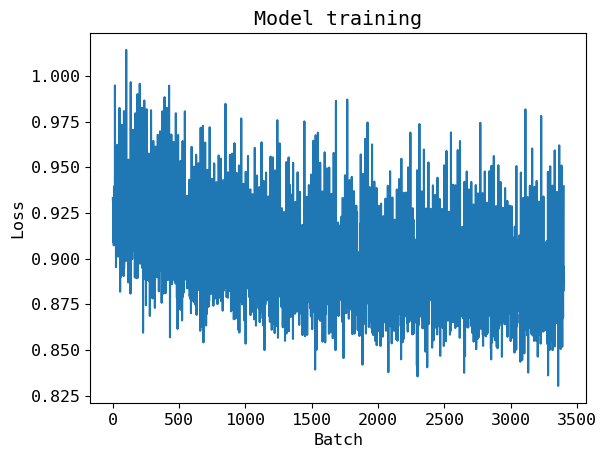

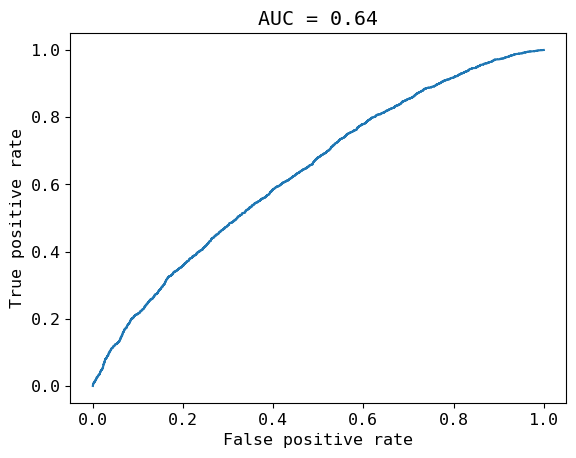

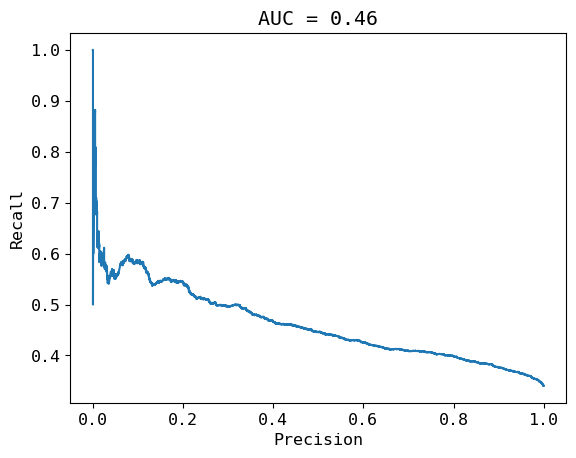

In [50]:
model = DeepSet(object_size=6, nhidden=10, hidden_channels=32, use_janossy=True).to(device)

ds, ds_train, ds_test, train_loader, test_loader = get_ds(autoshuffle_rows=True)

test = torch.stack((ds_train[0][0], ds_train[1][0]))
print(test.shape)
print(model(test))

losses = train(model, train_loader, n_epochs=200, lr=1e-4)

fig1, ax = plt.subplots()
ax.plot(np.arange(len(losses)), losses)
ax.set_xlabel(f'Batch')
ax.set_ylabel(f'Loss')
ax.set_title(f'Model training')

predictions, fig2 = check_model_roc(model=model, ds=ds_test);
predictions, fig3 = check_model_precrec(predictions=predictions);

export_figures(f'{repo_dir}/notebooks/results/6_ML_classifier_janossy.pdf', [fig1, fig2, fig3])

Janossy pooling - correlated

Model: DeepSet(
  (element_wise_leps): Sequential(
    (0): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
          )
          (linear1): Linear(in_features=4, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=4, bias=True)
          (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (element_wise_jets): Sequential(
    (0): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantiz

Epoch 199 | Batch 16 | Loss 0.936879575252533 | ZHH 640.0 | ZZH 1408.0: 100%|██████████| 200/200 [10:46<00:00,  3.23s/it] 


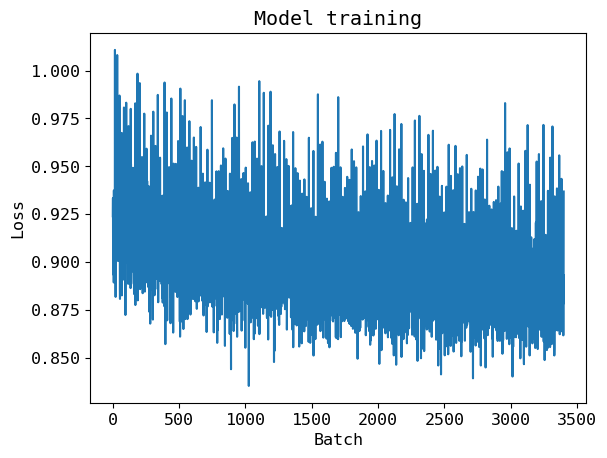

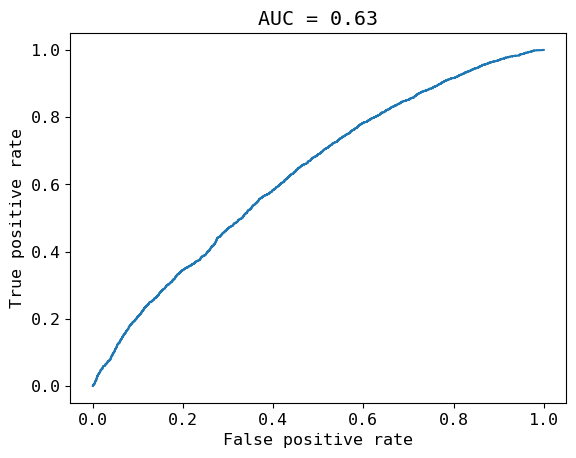

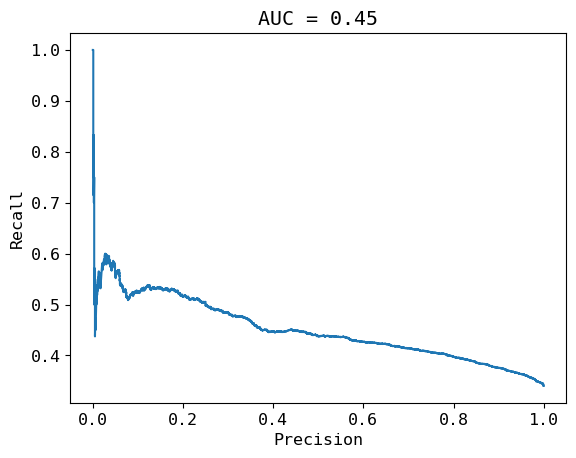

In [52]:
model = DeepSet(object_size=6, nhidden=10, hidden_channels=32, use_janossy=True).to(device)

ds, ds_train, ds_test, train_loader, test_loader = get_ds(autoshuffle_rows=False)

test = torch.stack((ds_train[0][0], ds_train[1][0]))
print(test.shape)
print(model(test))

losses = train(model, train_loader, n_epochs=200, lr=1e-4)

fig1, ax = plt.subplots()
ax.plot(np.arange(len(losses)), losses)
ax.set_xlabel(f'Batch')
ax.set_ylabel(f'Loss')
ax.set_title(f'Model training')

predictions, fig2 = check_model_roc(model=model, ds=ds_test);
predictions, fig3 = check_model_precrec(predictions=predictions);

export_figures(f'{repo_dir}/notebooks/results/6_ML_classifier_janossy_cor.pdf', [fig1, fig2, fig3])

Pytorch Geometric

In [ ]:
if False:
    from torchviz import make_dot
    dummy = model(ds_train[0])
    make_dot(dummy, params=dict(list(model.named_parameters())))#.render("rnn_torchviz", format="png")

Transformer correlated-shuffled

Tesla V100-PCIE-32GB
Model: Sequential(
  (0): Flatten(start_dim=1, end_dim=2)
  (1): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=24, out_features=24, bias=True)
    )
    (linear1): Linear(in_features=24, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=24, bias=True)
    (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (2): AvgPool1d(kernel_size=(24,), stride=(24,), padding=(0,))
)
Parameters: 102872
torch.Size([1, 6, 4])
tensor([[2.9802e-08]], device='cuda:0', grad_fn=<SqueezeBackward1>)


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 249 | Batch 16 | Loss 0.1041218712925911 | ZHH 650.0 | ZZH 1398.0: 100%|██████████| 250/250 [09:09<00:00,  2.20s/it] 


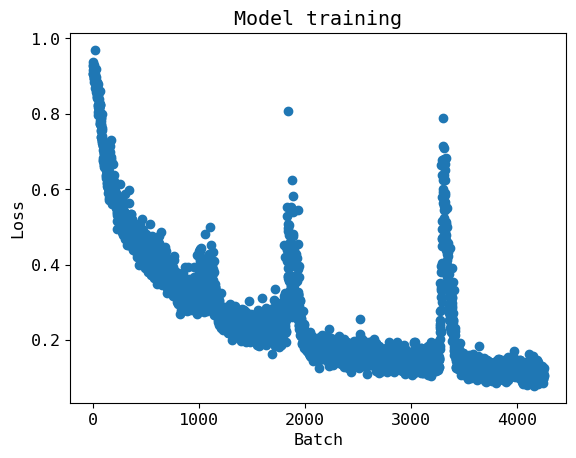

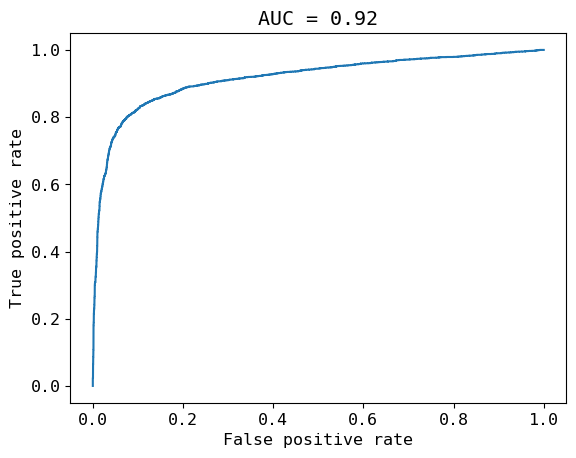

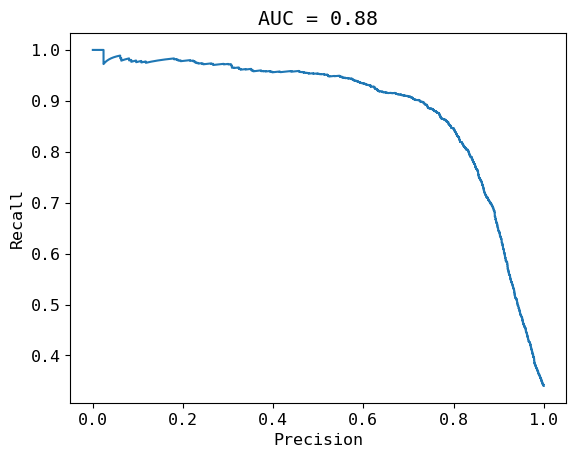

In [46]:
ds, ds_train, ds_test, train_loader, test_loader = get_ds(autoshuffle_rows=False, )

transformer = nn.Sequential(*[
    nn.Flatten(1, 2),
    nn.TransformerEncoderLayer(d_model=24, nhead=2, batch_first=True, dim_feedforward=2048).to(device),
    nn.AvgPool1d(24),
])

print('Model: %s\nParameters: %i' %
            (transformer, sum(p.numel() for p in transformer.parameters())))

print(ds[0][0].unsqueeze(0).shape)
print(transformer(ds[0][0].unsqueeze(0)))

losses = train(transformer, train_loader, n_epochs=250, lr=1e-2)

fig1, ax = plt.subplots()
ax.plot(np.arange(len(losses)), losses)
ax.set_xlabel(f'Batch')
ax.set_ylabel(f'Loss')
ax.set_title(f'Model training')

predictions, fig2 = check_model_roc(model=transformer, ds=ds_test);
predictions, fig3 = check_model_precrec(predictions=predictions);

export_figures(f'{repo_dir}/notebooks/results/6_ML_classifier_correlated.pdf', [fig1, fig2, fig3])

Transformer sort_rows_by_energy

Tesla V100-PCIE-32GB
Model: Sequential(
  (0): Flatten(start_dim=1, end_dim=2)
  (1): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=24, out_features=24, bias=True)
    )
    (linear1): Linear(in_features=24, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=24, bias=True)
    (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (2): AvgPool1d(kernel_size=(24,), stride=(24,), padding=(0,))
)
Parameters: 102872
torch.Size([1, 6, 4])
tensor([[-4.9671e-09]], device='cuda:0', grad_fn=<SqueezeBackward1>)


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 249 | Batch 16 | Loss 0.1892065554857254 | ZHH 615.0 | ZZH 1433.0: 100%|██████████| 250/250 [13:49<00:00,  3.32s/it] 


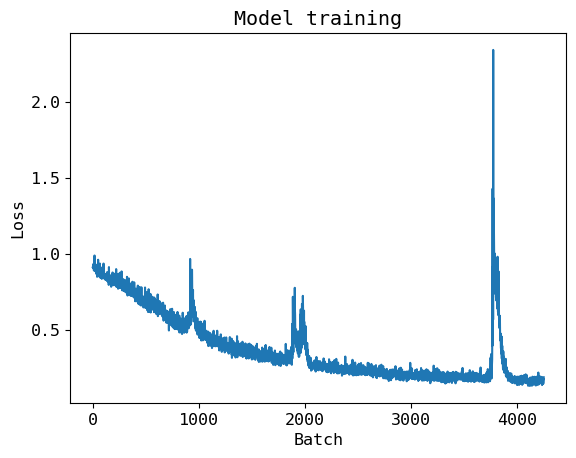

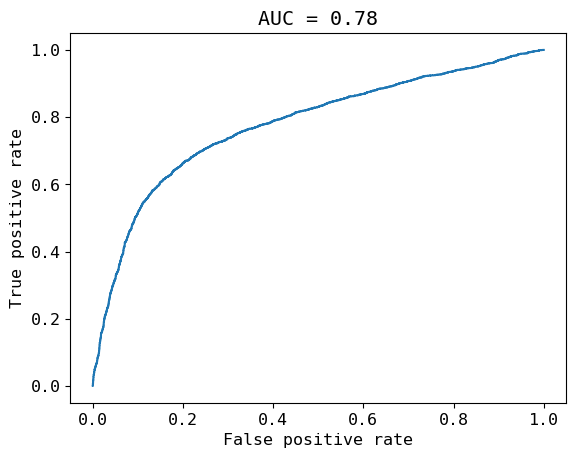

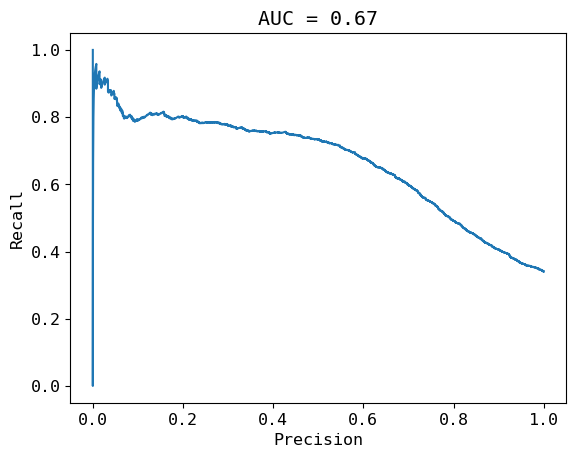

: 

In [55]:
ds, ds_train, ds_test, train_loader, test_loader = get_ds(autoshuffle_rows=False, sort_rows_by_energy=True)

transformer = nn.Sequential(*[
    nn.Flatten(1, 2),
    nn.TransformerEncoderLayer(d_model=24, nhead=2, batch_first=True, dim_feedforward=2048).to(device),
    nn.AvgPool1d(24),
])

print('Model: %s\nParameters: %i' %
            (transformer, sum(p.numel() for p in transformer.parameters())))

print(ds[0][0].unsqueeze(0).shape)
print(transformer(ds[0][0].unsqueeze(0)))

losses = train(transformer, train_loader, n_epochs=250, lr=1e-2)

# Plot results
fig1, ax = plt.subplots()
ax.plot(np.arange(len(losses)), losses)
ax.set_xlabel(f'Batch')
ax.set_ylabel(f'Loss')
ax.set_title(f'Model training')

predictions, fig2 = check_model_roc(model=transformer, ds=ds_test);
predictions, fig3 = check_model_precrec(predictions=predictions);

#export_figures(f'{repo_dir}/notebooks/results/6_ML_classifier_energy_sorted.pdf', [fig1, fig2, fig3])
transformer_esorted = transformer

SKlearn

In [245]:
from sklearn.model_selection import train_test_split

X, y = get_data(df, uncorrelated=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [172]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)

In [173]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int32), array([5754, 2907]))

In [174]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_score = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

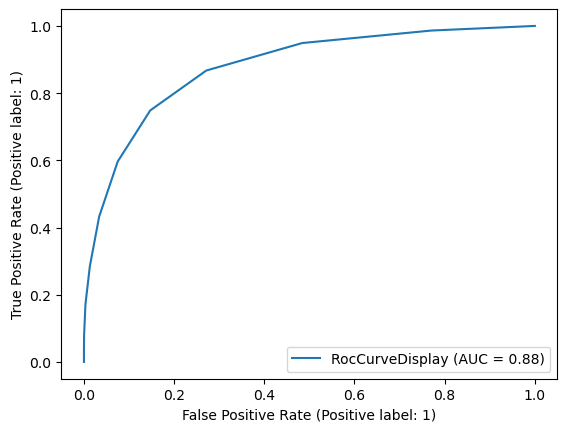

In [175]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(clf, X_test, y_test, name='RocCurveDisplay')

Uncorrelated

In [176]:
X, y = get_data(df, uncorrelated=True)

In [177]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [178]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)

In [179]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_score = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

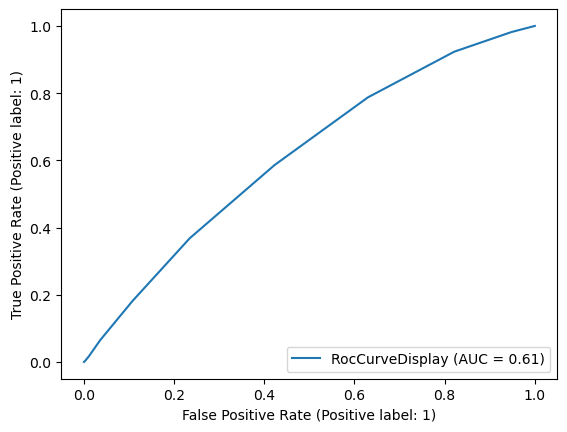

In [180]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(clf, X_test, y_test, name='RocCurveDisplay')